# ZRE Naive Autotune
Author: Marek Hric xhricma00  
GitHub repo: https://github.com/Marek324/butfit-zre/  
Google Collab notebook: TDB after completion i guess

Original audio source: https://www.openslr.org/resources/12/dev-clean.tar.gz

## Project pipeline
1. Load downsampled audio file ([code](#load-downsampled-audio-file))
2. Center the signal ([code](#center))
3. Frame the signal ([code](#framing))
7. Synthesis ([code](#synthesis))

#### Plotting

In [477]:
# set to True for plots
PLOT = True

### Load downsampled audio file

In [535]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import scipy.signal as sg
import librosa
from IPython.display import Audio, display

!pip install vad
from vad import EnergyVAD

s, Fs = librosa.load("input.wav", sr=16000)
s = librosa.effects.preemphasis(s, coef=0.2)

print(f"Signal length: {len(s)} samples")
print(f"Duration: {len(s)/Fs:.2f} s")

display(Audio(s, rate=Fs))

Signal length: 160000 samples
Duration: 10.00 s


### Center

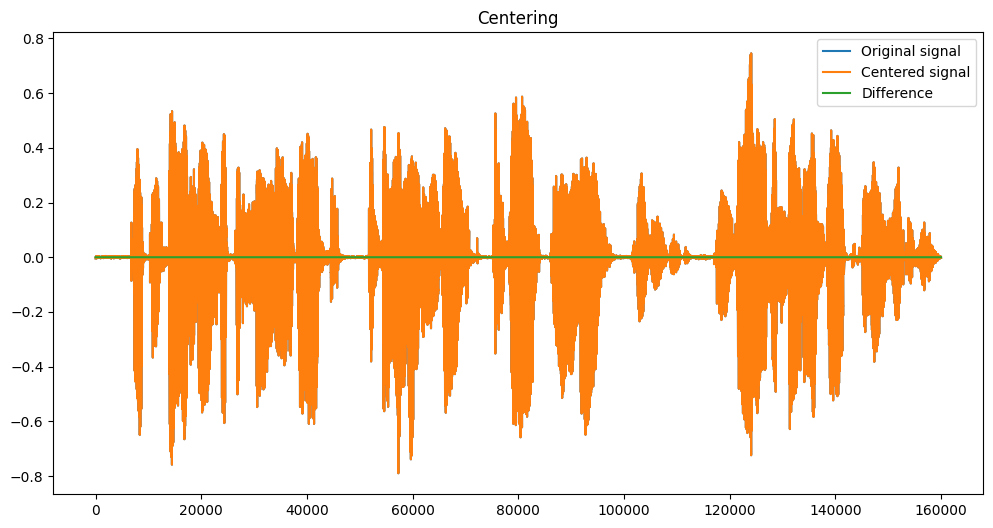

In [536]:
sc = s - np.mean(s)

if PLOT:
  plt.figure(figsize=(12,6))
  plt.title('Centering')
  plt.plot(s, label='Original signal')
  plt.plot(sc, label='Centered signal')
  plt.plot(s-sc, label='Difference')
  plt.legend()
  plt.show()

s = sc

<ipython-input-537-f0c53a862b05>:5: UserWarning: With fmin=65.406, sr=16000 and frame_length=320, less than two periods of fmin fit into the frame, which can cause inaccurate pitch detection. Consider increasing to fmin=100.000 or frame_length=491.
  f0s, voiced, _ = librosa.pyin(


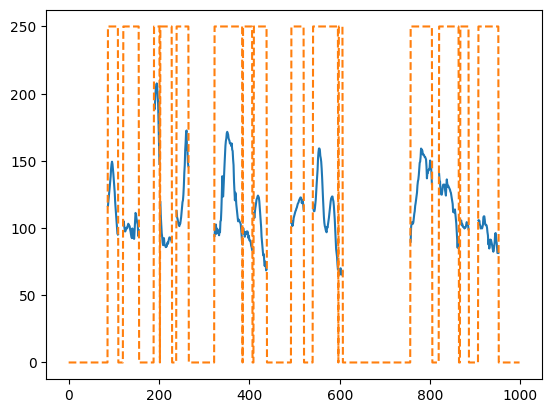

In [537]:
fl = int(Fs * 0.02)
fo = int(Fs * 0.01)
fs = fl - fo

f0s, voiced, _ = librosa.pyin(
    s,
    fmin = librosa.note_to_hz('C2'),
    fmax = librosa.note_to_hz('C6'),
    sr = Fs,
    frame_length = fl,
    hop_length = fs,
    center = False
)

if PLOT:
  plt.plot(f0s)
  plt.plot(voiced*250, "--")
  plt.show()

In [538]:
seq = []
seqs = []

for i, v in enumerate(voiced):
  if v == 0:
    if len(seq) > 0:
      seqs.append(seq)
    seq = []
  else:
    if not np.isnan(f0s[i]):
      seq.append([i, int(f0s[i])])
# last
if len(seq) > 0:
    seqs.append(seq)

first_seq_f0s = [item[1] for item in seqs[0]]
F0base = int(np.mean(first_seq_f0s))
print(F0base)
print(seqs[1])


125
[[121, 104], [122, 105], [123, 101], [124, 99], [125, 97], [126, 97], [127, 99], [128, 100], [129, 99], [130, 100], [131, 102], [132, 103], [133, 102], [134, 101], [135, 101], [136, 99], [137, 97], [138, 95], [139, 93], [140, 92], [141, 99], [142, 95], [143, 92], [144, 92], [145, 91], [146, 98], [147, 106], [148, 111], [149, 110], [150, 107], [151, 105], [152, 103], [153, 102], [154, 94], [155, 98]]


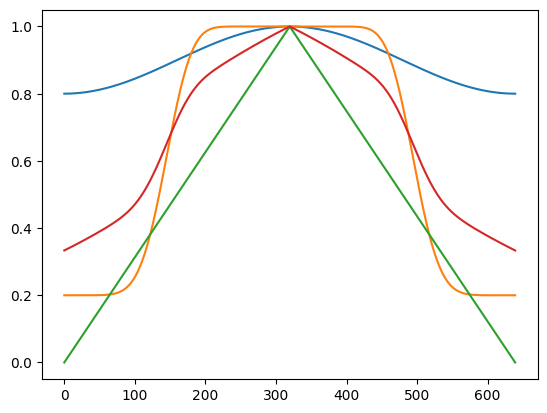

In [574]:
a = sg.windows.general_hamming(fl*2, 0.9)
b = sg.windows.kaiser_bessel_derived(fl*2, np.pi*15)*0.8 + 0.2
c = sg.windows.bartlett(fl*2)
plt.plot(a)
plt.plot(b)
plt.plot(c)
plt.plot((a+b+c)/3)

### GCI detection

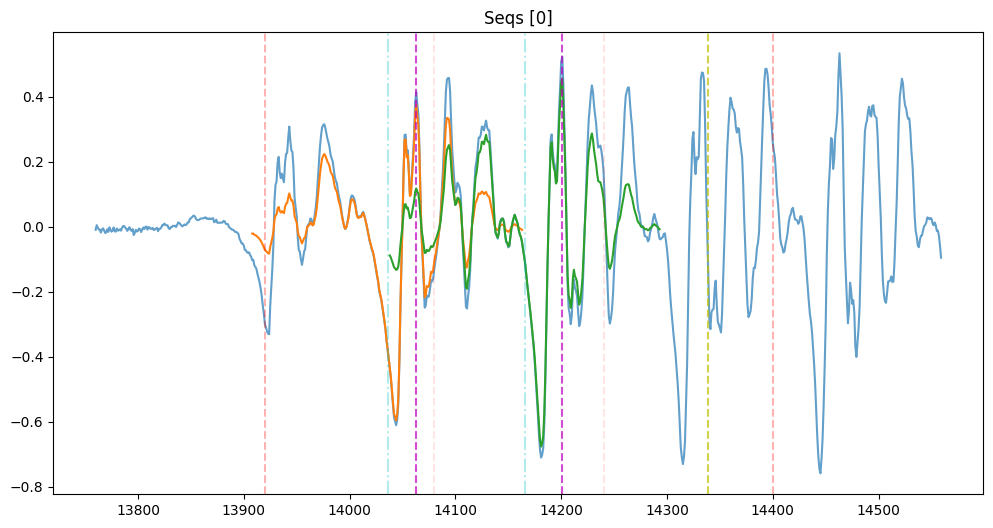

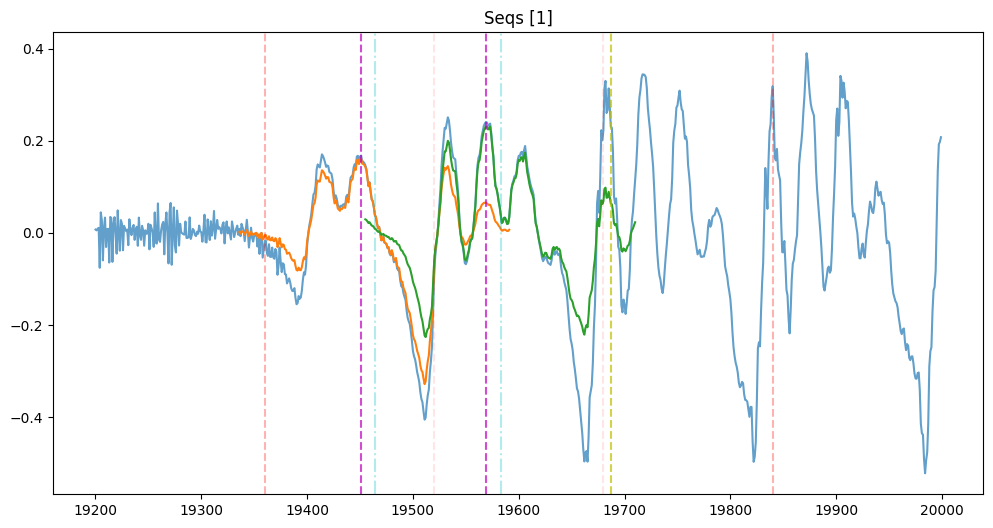

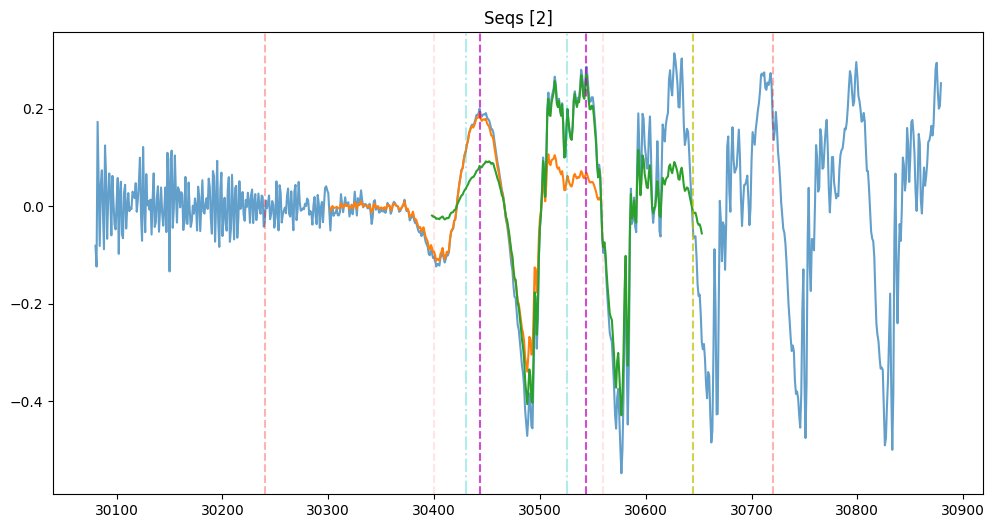

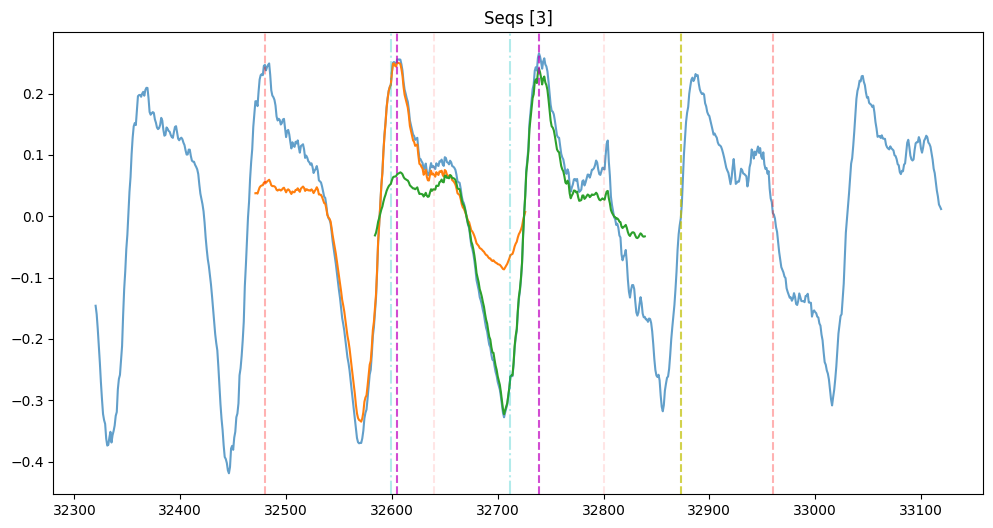

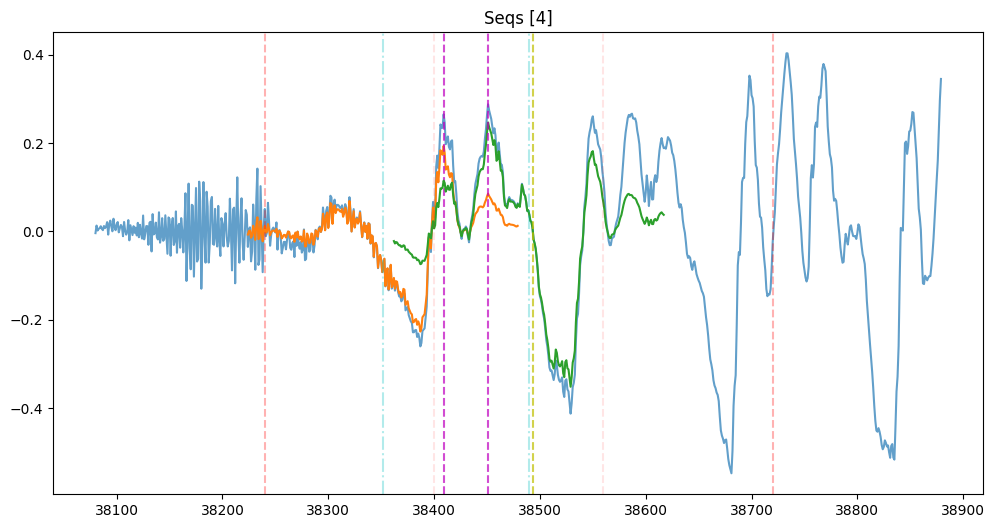

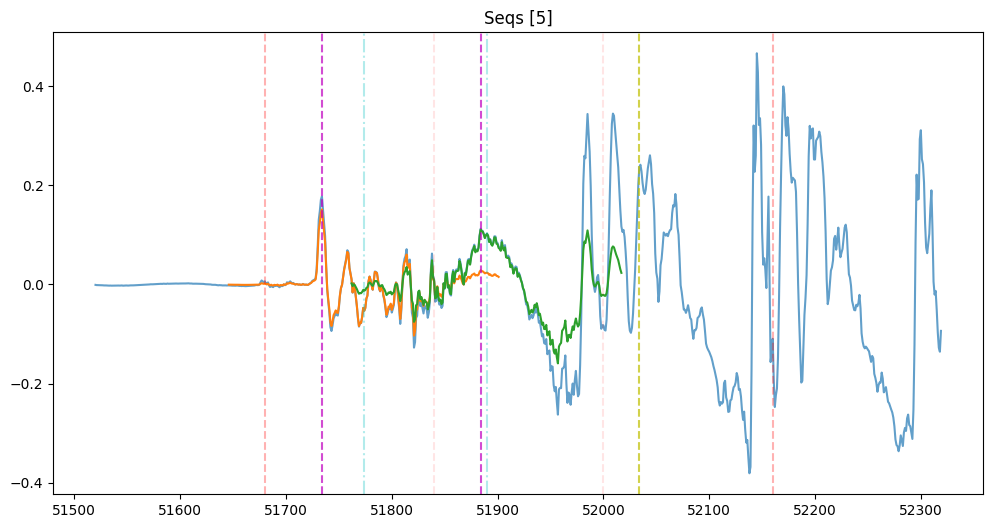

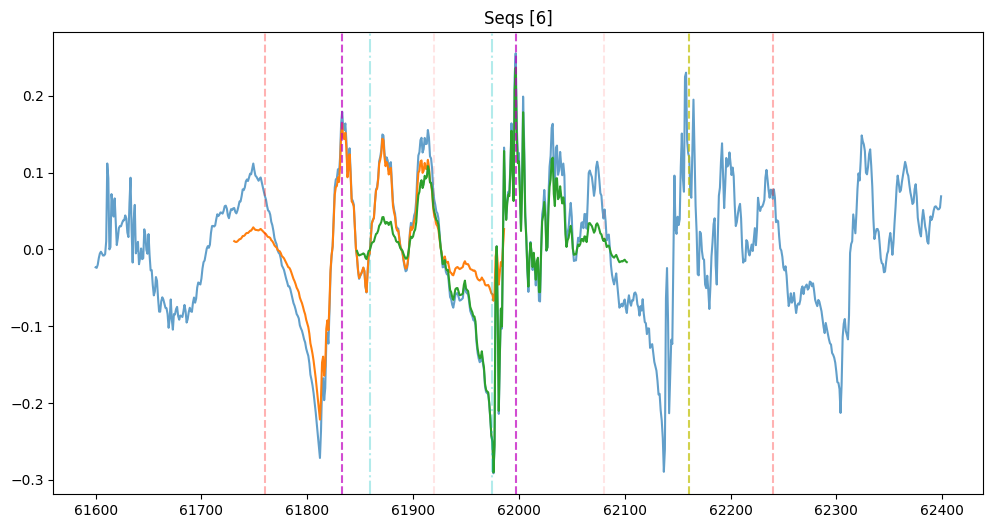

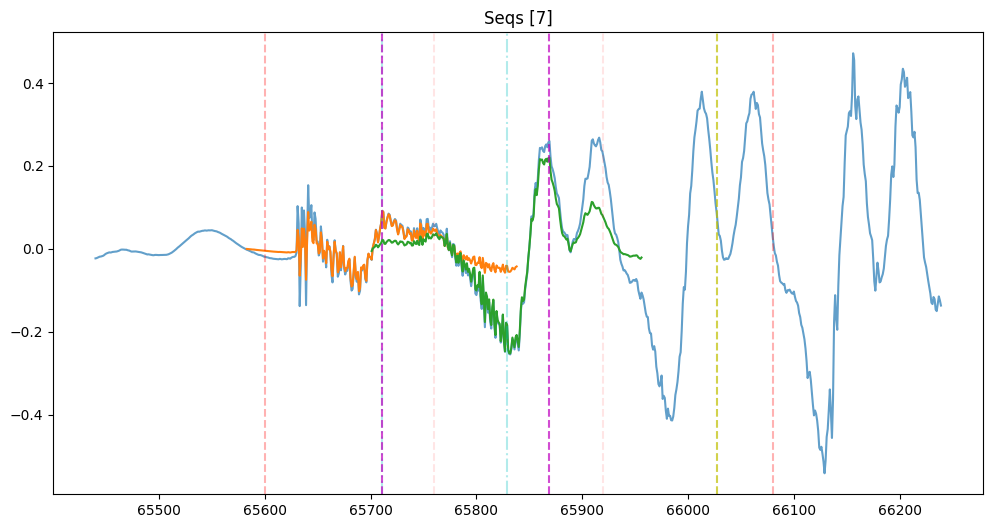

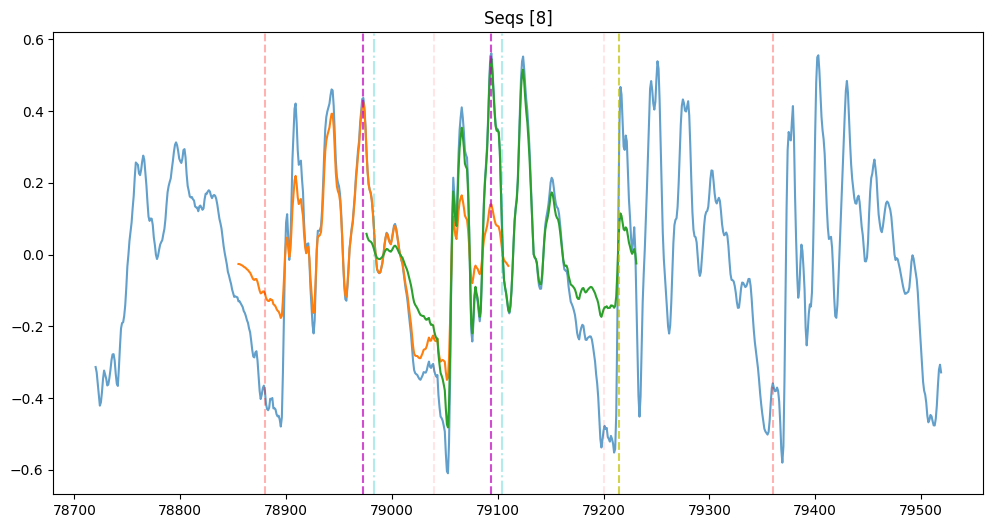

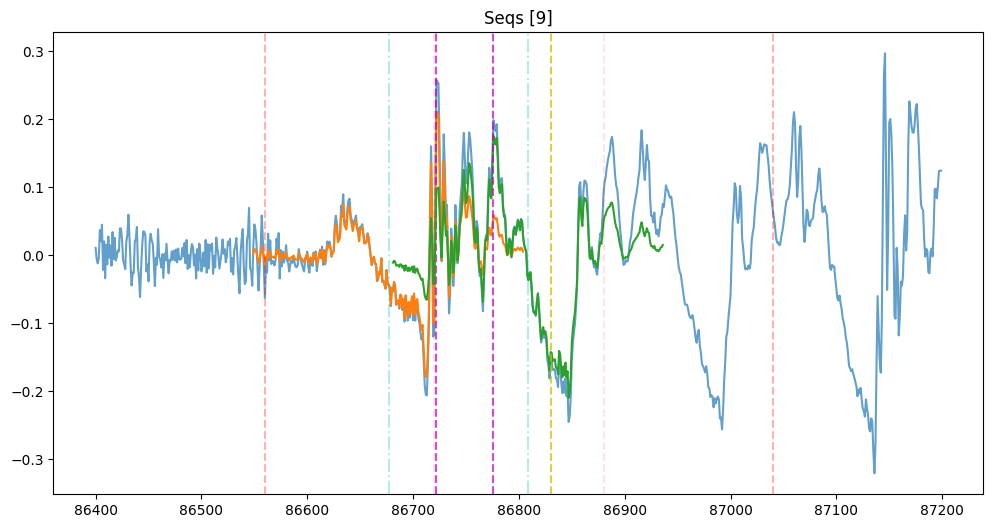

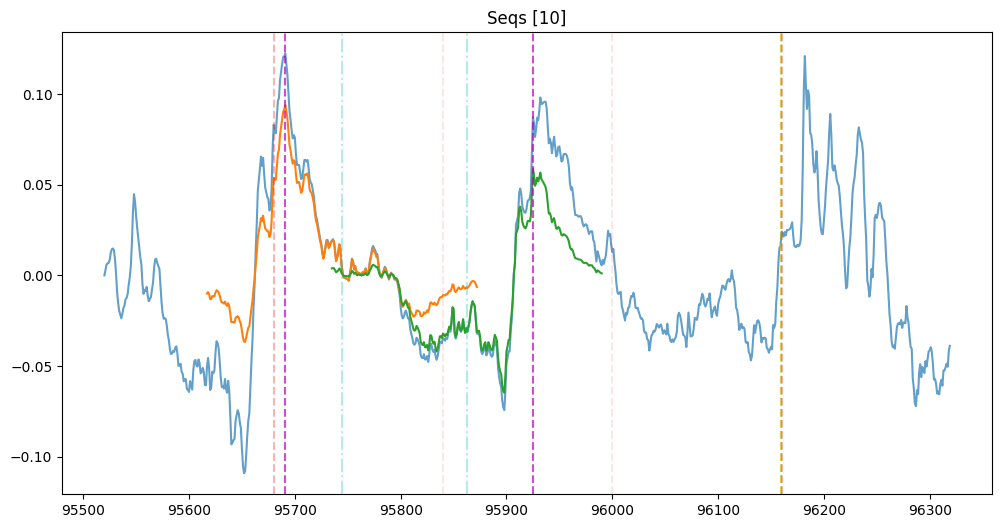

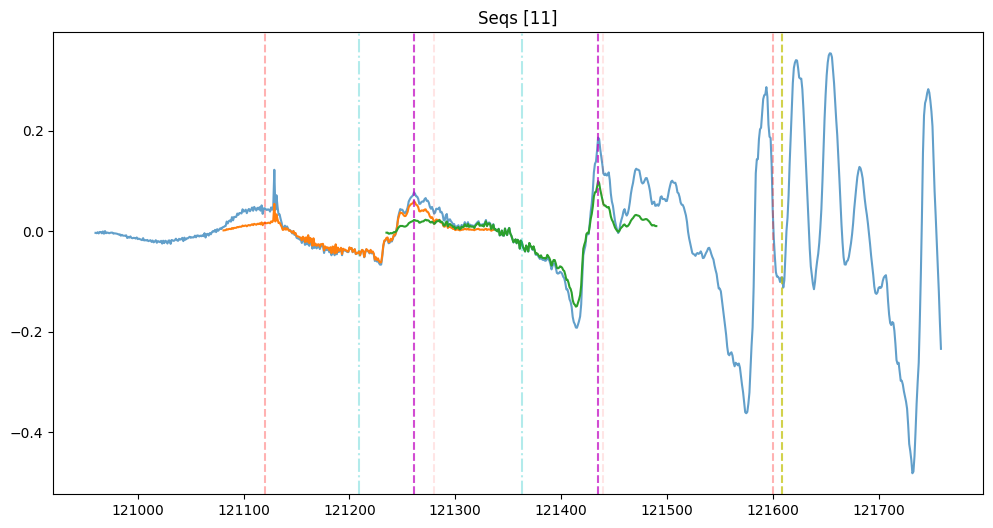

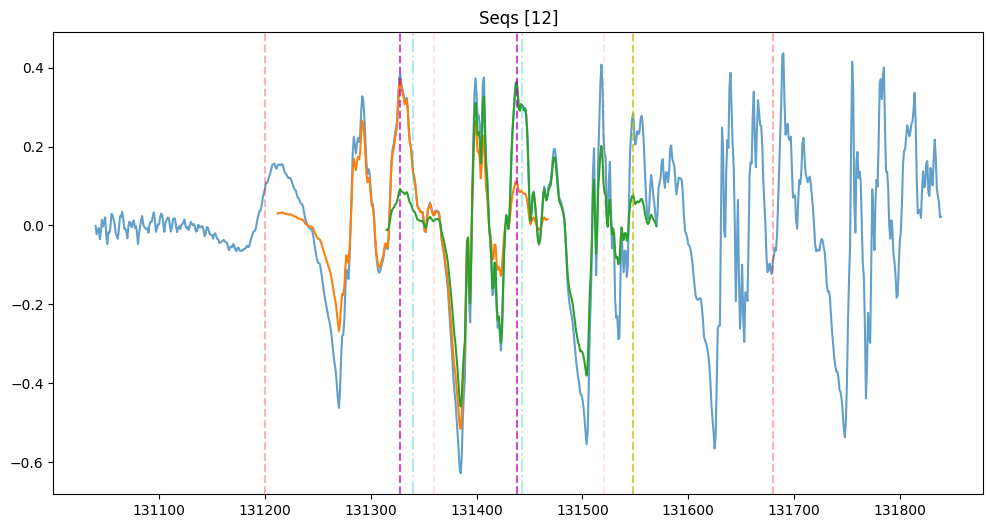

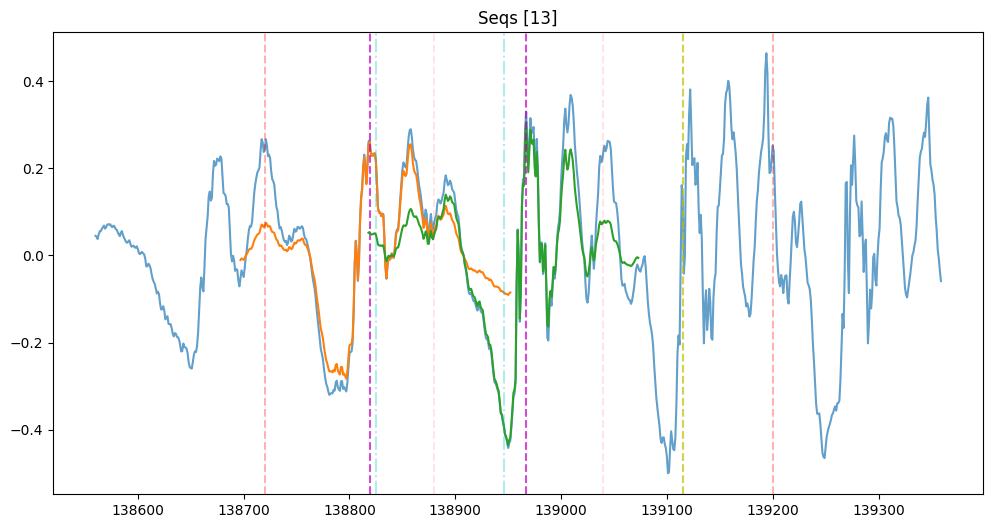

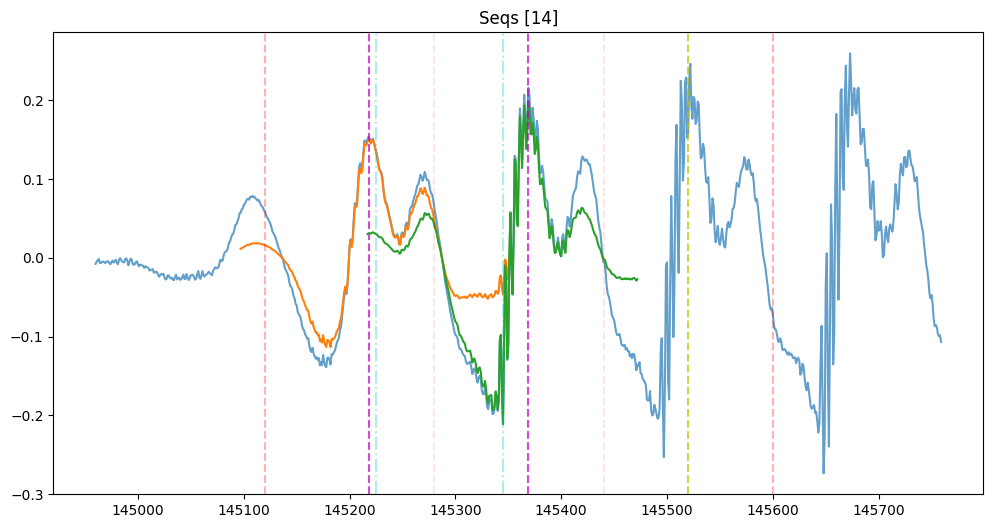

In [579]:
def f_start(f_idx:int, fs:int = 160) -> int:
  return f_idx * fs

pitch_marks = []
for i in range(len(seqs)):
  fi = seqs[i][0]
  start = f_start(fi[0])
  a_mark = start + fi[1]

  search_range = int(fs*0.8)
  weight_window = (
    sg.windows.general_hamming(search_range*2, 0.7) +
    (sg.windows.kaiser_bessel_derived(search_range*2, np.pi*15)*0.8 + 0.2) +
    sg.windows.bartlett(search_range*2)
  ) / 3

  search_window = s[a_mark-search_range:a_mark+search_range] * weight_window
  mark = a_mark + np.argmax(search_window) - search_range

  fi2 = seqs[i][1]
  start2 = f_start(fi2[0])
  err_w = 0.35
  a_mark2 = int(start2 + (1-err_w)*fi2[1] + err_w*(mark - a_mark))

  search_window2 = s[a_mark2-search_range:a_mark2+search_range] * weight_window
  mark2 = a_mark2 + np.argmax(search_window2) - search_range

  seq_pm = [0, int(mark), int(mark2)]
  for j in range(3, len(seqs[i])):
    seq_pm.append(0)

  pitch_marks.append(seq_pm)

  if PLOT:
    zoom_s = start - fs
    zoom_e = start + 2 * fl
    zoom = np.arange(zoom_s, zoom_e)
    plt.figure(figsize=(12,6))
    plt.title(f"Seqs [{i}]")
    plt.plot(zoom, s[zoom_s:zoom_e], alpha=0.7)

    sw_zoom = np.arange(a_mark-search_range, a_mark+search_range)
    plt.plot(sw_zoom, search_window, alpha=1)

    plt.axvline(a_mark, color='c', linestyle='-.', alpha=0.3)
    plt.axvline(mark, color='m', linestyle='--', alpha=0.7)

    sw_zoom2 = np.arange(a_mark2-search_range, a_mark2+search_range)
    plt.plot(sw_zoom2, search_window2, alpha=1)

    plt.axvline(a_mark2, color='c', linestyle='-.', alpha=0.3)
    plt.axvline(mark2, color='m', linestyle='--', alpha=0.7)

    plt.axvline(mark2 + (mark2-mark), color='y', linestyle='--', alpha=0.7)

    plt.axvline(start, color='r', linestyle='--', alpha=0.3)
    plt.axvline(start + fl, color='r', linestyle='--', alpha=0.1)
    plt.axvline(start2, color='r', linestyle='--', alpha=0.1)
    plt.axvline(start2 + fl, color='r', linestyle='--', alpha=0.3)
    plt.show()

[0, 14063, 14201, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


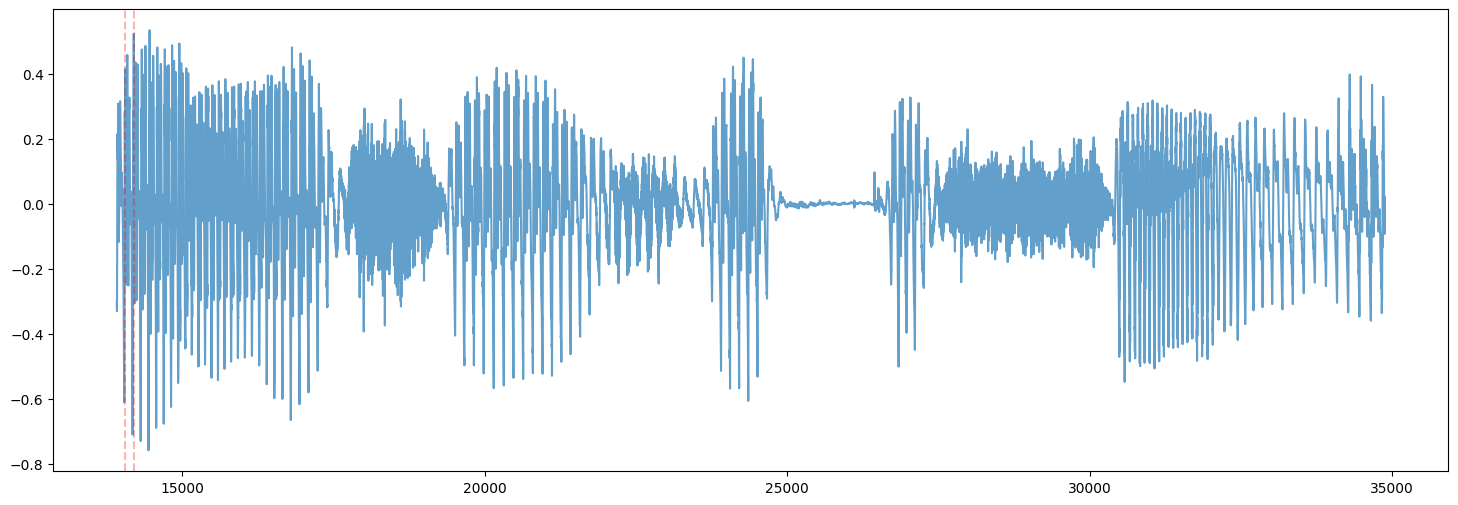

In [587]:
def ps_frame(s, Fs, seq, pitch_marks):
  ...

seq_i = 0
seq = seqs[seq_i]
print(pitch_marks[seq_i])


if PLOT:
  zoom_s = f_start(seq[0][0])
  zoom_e = f_start(seq[-1][0]) + f_start(seq[-1][0])
  zoom = np.arange(zoom_s, zoom_e)
  plt.figure(figsize=(18,6))
  plt.plot(zoom, s[zoom_s:zoom_e], alpha=0.7)

  for i in range(len(pitch_marks)):
    if pitch_marks[seq_i][i] == 0:
      continue
    plt.axvline(pitch_marks[seq_i][i], color='r', linestyle='--', alpha=0.3)